## Visualize image-specific class saliency with backpropagation

---

A quick demo of creating saliency maps for CNNs using [FlashTorch 🔦](https://github.com/MisaOgura/flashtorch).


❗This notebook is for those who are using this notebook in **Google Colab**.

If you aren't on Google Colab already, please head to the Colab version of this notebook **[here](https://colab.research.google.com/github/MisaOgura/flashtorch/blob/master/examples/visualise_saliency_with_backprop_colab.ipynb)** to execute.

---

The gradients obtained can be used to visualise an image-specific class saliency map, which can gives some intuition on regions within the input image that contribute the most (and least) to the corresponding output.

More details on saliency maps: [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf).

### 0. Set up

A GPU runtime is available on Colab for free, from the `Runtime` tab on the top menu bar.

It is **recommended to use GPU** as a runtime for the enhanced speed of computation.

In [1]:
# Install flashtorch

!pip install flashtorch
!pip install pascal-voc-tools
!pip install -U -q PyDrive
!pip install tqdm

  Created wheel for flashtorch: filename=flashtorch-0.1.3-cp36-none-any.whl size=26248 sha256=0d0ee24f54f93e78309984276a5c4989a6361a2aedd58cd74ad7bbf32b0eaef4
  Stored in directory: /root/.cache/pip/wheels/03/6d/b1/2d3c5987b69e900fcceceeef39d3ed92dfe46ba1359b9c79f8
Successfully built flashtorch
     |████████████████████████████████| 122kB 3.5MB/s 


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os , json , torch , scipy , pickle , tqdm , warnings
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from google.colab import files
import cv2 as cv
from flashtorch.utils import apply_transforms, load_image , denormalize , format_for_plotting , ImageNetIndex , standardize_and_clip
from flashtorch.saliency import Backprop
from skimage.measure import label
import pascal_voc_tools

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

warnings.filterwarnings("ignore", category=UserWarning)

Define functions

In [3]:
def get_top_5_1(input_arr):
  top5_idx = np.argpartition(input_arr,-5)[-5:]
  top5 = input_arr[top5_idx]
  top1_idx = top5_idx[np.argmax(top5)]
  top1 = input_arr[top1_idx]
  
  return top1_idx , top5_idx
  


  
def get_IoU(pred_coords,truth_coords):
    """
    from https://github.com/zalkikar/BBOX_GradCAM/blob/master/BBOX_GRADCAM_demo_example.ipynb
    """
    [xmin_pred , ymin_pred] , [xmax_pred, ymax_pred] = pred_coords
    [xmin_true , ymin_true] , [xmax_true, ymax_true] = truth_coords

    # area of prediction and truth rectangles
    pred_area = (xmax_pred - xmin_pred)*(ymax_pred - ymin_pred)
    truth_area = (xmax_true - xmin_true)*(ymax_true - ymin_true)

    # coords of intersection rectangle
    x1 = max(xmin_pred, xmin_true)
    y1 = max(ymin_pred, ymin_true)
    x2 = min(xmax_pred, xmax_true)
    y2 = min(ymax_pred, ymax_true)

    # area of intersection rectangle
    interArea = max(0, x2 - x1) * max(0, y2 - y1)
    
    # intersection over union 
    iou = interArea / float(pred_area + truth_area - interArea)

    return iou

def apply_transforms_MP(image, size=224):
    """Transforms a PIL image to torch.Tensor.

    Applies a series of tranformations on PIL image including a conversion
    to a tensor. The returned tensor has a shape of :math:`(N, C, H, W)` and
    is ready to be used as an input to neural networks.

    First the image is resized to 256, then cropped to 224. The `means` and
    `stds` for normalisation are taken from numbers used in ImageNet, as
    currently developing the package for visualizing pre-trained models.

    The plan is to to expand this to handle custom size/mean/std.

    Args:
        image (PIL.Image.Image or numpy array)
        size (int, optional, default=224): Desired size (width/height) of the
            output tensor

    Shape:
        Input: :math:`(C, H, W)` for numpy array
        Output: :math:`(N, C, H, W)`

    Returns:
        torch.Tensor (torch.float32): Transformed image tensor

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    if not isinstance(image, Image.Image):
        image = F.to_pil_image(image)

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize((size,size)),
        #transforms.CenterCrop(size),
        transforms.ToTensor(),
        #transforms.Normalize(means, stds)
    ])

    tensor = transform(image).unsqueeze(0)

    tensor.requires_grad = True

    return tensor

def find_bb(mask,xscale=1,yscale=1):
  
  y_min , x_min = np.min(np.where(mask == 1),axis=1)
  y_max , x_max = np.max(np.where(mask == 1),axis=1)

  return x_min*xscale , y_min*yscale , x_max*xscale , y_max*yscale


def get_true_bb(annotation,idx=0):

  parser = pascal_voc_tools.XmlParser()

  p = parser.load(annotation)

  p_vals = p['object'][idx]['bndbox']

  xmin_t = np.int(p_vals['xmin'])
  xmax_t = np.int(p_vals['xmax'])
  ymin_t = np.int(p_vals['ymin'])
  ymax_t = np.int(p_vals['ymax'])

  true_bb = ((xmin_t,ymin_t) , (xmax_t,ymax_t))

  return true_bb

def get_parse(annotation):

  parser = pascal_voc_tools.XmlParser()

  p = parser.load(annotation)

  return p

class DataParser():
  def __init__(self,image_folder,annotation_folder):
    # Setup dict with index, name of image and name of annotation
    # for easy access
    self.image_folder = image_folder
    self.annotation_folder = annotation_folder
    self.parser = pascal_voc_tools.XmlParser()
    
    self.ground_truth_mat = scipy.io.loadmat('drive/My Drive/Colab Notebooks/DD2412_Project/ILSVRC2015_clsloc_validation_ground_truth.mat')['rec'][0] # Ground truth idx in synset for each img

    self.__create_map_clsloc()
    #self.__build_dict()


  def __create_map_clsloc(self):
    self.class_idx = json.load(open("drive/My Drive/Colab Notebooks/DD2412_Project/imagenet_class_index.json")) # Translate from classification idx to imagenet wid
    f = open('drive/My Drive/Colab Notebooks/DD2412_Project/map_clsloc.txt','r')
    
    self.clsloc_map = {}
    self.pred_map = {}

    lines = f.readlines()

    for line in lines:
      wnid , synset_idx , _ = line.split(' ')
      self.clsloc_map[wnid] = int(synset_idx)

    for key , val in self.class_idx.items():
      
      wnid = val[0]
      imgnet_class = int(key)

      self.pred_map[imgnet_class] = self.clsloc_map[wnid]
      


  def __build_dict(self):
    files = next(os.walk(self.image_folder))[2]
    self.data_dict = {}
    
    for img in files:
      name = img.split('.')[0]
      self.data_dict[name] = {}
      info = self.parser.load(os.path.join(self.annotation_folder, name + '.xml'))['object']

      for i,obj in enumerate(info):
        obj_class = info[i]['name']
        bbox = info[i]['bndbox']
        
        xmin_t = np.int(bbox['xmin'])
        xmax_t = np.int(bbox['xmax'])
        ymin_t = np.int(bbox['ymin'])
        ymax_t = np.int(bbox['ymax'])
        
        self.data_dict[name][obj_class] = ((xmin_t,ymin_t) , (xmax_t,ymax_t))

  def write_to_savefile(self,pred_classes,bboxes,savefile):
    """
    Writes to prediction savefile specified by rules in ILSVRC2015 competition.
    Format: 

    <IMG1_PRED_CLASS_1> <XMIN> <YMIN> <XMAX> <YMAX> <PRED_CLASS_2> <XMIN> <YMIN> <XMAX> <YMAX> ... <PRED_CLASS_5> <XMIN> <YMIN> <XMAX> <YMAX>
    <IMG2_PRED_CLASS_1> <XMIN> <YMIN> <XMAX> <YMAX> <PRED_CLASS_2> <XMIN> <YMIN> <XMAX> <YMAX> ... <PRED_CLASS_5> <XMIN> <YMIN> <XMAX> <YMAX>
    ...

    For each image in val set.

    pred_classes and bboxes are lists of predicted classes and corresponding bounding boxes sorted after confidence
    in prediction. 
    """
    self.savefile = open(savefile,'a+')

    for pred_class , bbox in zip(pred_classes,bboxes):
      pred_imgnet_class_label = self.pred_map[pred_class]

      self.savefile.write(f'{pred_imgnet_class_label} {bbox[0][0]} {bbox[0][1]} {bbox[1][0]} {bbox[1][1]} ')

    self.savefile.write('\n')

    self.savefile.close()


  def get_image_info(self,img):
    return self.data_dict[img]

  def load_image(self,img):
    img = load_image(os.path.join(self.image_folder, img + '.JPEG'))
    return img

  def get_class(self,idx):
    return self.class_idx[f"{idx}"]

  def get_wnid(self,idx):
    return self.class_idx[f"{idx}"][0]

  def get_images(self):
    return sorted(list(self.data_dict.keys()))

  def visualize(self,image_name,pred_bb=None,mask=None,grad=None):
    """
    Img : PIL format
    """
    full_name = os.path.join(self.image_folder, image_name)
    img = cv.imread(full_name + '.JPEG')
    #obj = self.data_dict[image_name]

    fig = plt.figure(figsize=(10,10))
    ax1 , ax2 , ax3 = fig.subplots(nrows=1,ncols=3)
    """
    for key in obj.keys():  # Plots real bbs but requires all xml files - therefore discarded
      bb = obj[key]
      cv.rectangle(img,bb[0],bb[1],(0,255,0),1)
    """
    if pred_bb is not None:
      cv.rectangle(img,pred_bb[0],pred_bb[1],(0,0,255),1) # Showing predicted bbs on true size img
      
    ax1.imshow(img)

    if mask is not None:
      ax2.imshow(mask)
    else:
      fig.delaxes(ax2)

    if grad is not None:
      ax3.imshow(grad)
    else:
      fig.delaxes(ax3)

      
      

class ILSVRC_Pred():
  def __init__(self,network='alexnet'):
    self.network = network # alexnet, VGG16 , googlenet in paper
    
    if self.network == 'alexnet':
      self.network = models.alexnet(pretrained=True)
      self.img_size = 227
    elif self.network == 'vgg16':
      self.network = models.vgg16(pretrained=True)
      self.img_size = 224
    elif self.network == 'googlenet':
      self.network = models.googlenet(pretrained=True)
      self.img_size = 224
    elif self.network == 'resnet':
      self.network = models.resnet50(pretrained=True)
      self.img_size = 224
    elif self.network == 'inceptionv3':
      self.network = models.inception_v3(pretrained=True)
      self.img_size = 299
    
    self.model = Backprop(self.network)


  def transform_image(self,image):

    if not isinstance(image, Image.Image):
        image = F.to_pil_image(image)

    transform = transforms.Compose([
        transforms.Resize((self.img_size,self.img_size)),
        transforms.ToTensor()
    ])

    self.img_transf = transform(image).unsqueeze(0)

    self.img_transf.requires_grad = True

    #self.img_transf = apply_transforms_MP(image,self.img_size) # Resize and convert to tensor
    
    img_h , img_w = np.shape(image)[:-1]

    self.scale_x = img_w/self.img_size  # Used when scaling created bounding boxes to original img size
    self.scale_y = img_h/self.img_size

    return self.img_transf , self.scale_x , self.scale_y

  def predict(self,image,top_k=5):
    # Input image should have gone through transform_image

    pred = self.network(image).detach().numpy()[0] # Make prediction

    top5 = list(reversed(np.argsort(pred)[-top_k:]))

    return top5

  def compute_gradients(self,image,idx,use_gpu=True):
    gradients = self.model.calculate_gradients(image, idx, use_gpu=use_gpu) # Get gradients from backprop
    return gradients

  def create_mask(self,grad,lq=0.3,uq=0.95):
    max_grad = grad.abs().max(dim=0)[0] # Use max magnitude gradient across RGB channels
    
    up_q = np.quantile(max_grad,uq) #95th percentile
    lo_q = np.quantile(max_grad,lq) #30th percentil

    gtd_bgr = torch.ones(max_grad.shape,dtype=torch.uint8)
    gtd_fgr = torch.zeros(max_grad.shape,dtype=torch.uint8)
    
    mask = torch.ones(max_grad.shape,dtype=torch.uint8)*cv.GC_PR_BGD  #Initialize all values to be probable background (test with GC_PR_FGD too)
    mask[max_grad >= up_q] = cv.GC_FGD                    #Where grad > upper quantile -> set as definite foreground
    mask[max_grad <= lo_q] = cv.GC_BGD                    #Where grad < lower quantile -> set as definite background

    return mask

  def find_segment(self,mask,tensor,niter=1):
    # cv grabcut requires (h,w,c) and uint8 0-255 formtting of img, while 
    # input tensor is (c,h,w) and float16 0-1
    resized_img = np.array((format_for_plotting(tensor).detach()*255),dtype=np.uint8)

    bgdModel = np.zeros((1,65),np.float64) # Not sure why 65
    fgdModel = np.zeros((1,65),np.float64)

    grad_mask = mask.detach().numpy()

    # Set input_mask to either mask.copy() or test_mask.copy()
    input_mask = grad_mask.copy()

    # Get graph cut color segmentation of resized img -> augments input_mask
    # niter=1 => graphcut algo (i think)
    cv.grabCut(resized_img,input_mask,None,bgdModel,fgdModel,niter,cv.GC_INIT_WITH_MASK)

    # Extract possible and definite foreground pixels
    connected_mask = np.where((input_mask==2)|(input_mask==0),0,1).astype('uint8')

    # Find connected segments in mask
    segments = label(connected_mask,background=0)

    # Find largest segment
    max_group = np.unique(segments)[np.argmax(np.bincount(segments.flatten())[1:])] + 1

    # Create final segmentation mask
    foreground = np.where(segments == max_group,1,0)

    return foreground

  def find_bb(self,foreground):
    """
    Create bounding box around mask
    """
    ymin_p , xmin_p = np.min(np.where(foreground == 1),axis=1)
    ymax_p , xmax_p = np.max(np.where(foreground == 1),axis=1)

    tl_pred = (xmin_p,ymin_p) # Top Left corner
    br_pred = (xmax_p,ymax_p) # Bottom Right corner

    return tl_pred , br_pred

  def upscale_bb(self,bb,xscale,yscale):
    """
    Upscale bounding box to size of original img.
    """
    scaled_xmin = bb[0][0]*xscale
    scaled_xmax = bb[1][0]*xscale
    scaled_ymin = bb[0][1]*yscale
    scaled_ymax = bb[1][1]*yscale

    tl_pred_scaled = (int(scaled_xmin),int(scaled_ymin))
    br_pred_scaled = (int(scaled_xmax),int(scaled_ymax))

    return tl_pred_scaled , br_pred_scaled



MOUNT DRIVE AND CREATE PATH TO IMAGES

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
def create_results_backprop(network_name, img_size, heatmap_name=None):
  """
  option to add precomputed gradcam heatmaps in heatmap_name (pickle file), which have predictions from tf, which are
  more accurate than pytorch ones.
  """
  print(f"Computing results for {network_name} , {img_size} using {heatmap_name}")
  wd = './drive/My Drive/Colab Notebooks/DD2412_Project/'
  local_download_path = os.path.expanduser(f'{wd}ILSVRC2012_img_val')

  if heatmap_name is not None:
    heatmap_dict = pickle.load(open(os.path.join(wd,heatmap_name),'rb'))
    use_precomp_preds = True
  else:
    use_precomp_preds = False

  folder=os.path.join(wd,'ILSVRC2012_img_val/')
  img_names = sorted(os.listdir(folder))

  dp = DataParser(local_download_path,None)
  predictor = ILSVRC_Pred(network=network_name)
  image_size = 224

  n = len(img_names)

  for img_name in tqdm.tqdm(img_names):
    try:
      image = load_image(os.path.join(local_download_path,img_name))
    except (FileNotFoundError , IndexError):
      print(f"Could not find file {img_name}")
      break
    
    img , scale_x , scale_y = predictor.transform_image(image)

    if use_precomp_preds:
      top5 = [list_val[0] for list_val in heatmap_dict[img_name]]
    else:
      top5 = predictor.predict(img,5)

    bbs = []
    
    for pred_i in top5:
      grad = predictor.compute_gradients(img,pred_i,True)

      mask = predictor.create_mask(grad)

      segm = predictor.find_segment(mask,img)

      pred_bb = predictor.find_bb(segm)

      pred_bb_upscaled = predictor.upscale_bb(pred_bb,scale_x,scale_y)

      bbs.append(pred_bb_upscaled)


    dp.write_to_savefile(top5,bbs,os.path.join(wd,f'results_{network_name}_{n}_{image_size}_backprop.txt'))


In [ ]:
create_results_backprop('vgg16',224,'gradcam_plus_plus_heatmaps_VGG16_1000.p')
create_results_backprop('resnet',224,'gradcam_heatmaps_resnet_1000.p')

Computing results for vgg16 , 224 using gradcam_plus_plus_heatmaps_VGG16_1000.p


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


 11%|█         | 106/1000 [20:48<3:00:24, 12.11s/it]

### For debugging

In [ ]:
predictor = ILSVRC_Pred(network=network_name)

i = 1

t_load_img_tot = 0
t_transf_img_tot = 0
t_predict_img_tot = 0
t_grad_tot = 0
t_mask_tot = 0
t_segm_tot = 0
t_bb_tot = 0
t_write_tot = 0

t_start = time.time()

t_it_start = time.time()


img_name = local_download_path + f'/ILSVRC2012_val_{i:08d}.JPEG'
image = load_image(img_name)
image_size = 227

print(img_name)
t_load_img = time.time()

img , xscale , yscale = predictor.transform_image(image,size=image_size)

t_transf_img = time.time()

top5 = predictor.predict(img,5)

t_predict_img = time.time()  
bbs = []

for pred_i in top5:
  t_iter = time.time()
  grad = predictor.compute_gradients(img,pred_i,True)
  t_grad = time.time()
  mask = predictor.create_mask(grad)
  t_mask = time.time()
  segm = predictor.find_segment(mask,img)
  t_segm = time.time()
  pred_bb = predictor.find_bb(segm)
  t_bb = time.time()
  scaled_bb = predictor.upscale_bb(pred_bb,xscale,yscale)
  bbs.append(scaled_bb)

  t_grad_tot += t_grad - t_iter
  t_mask_tot += t_mask - t_grad
  t_segm_tot += t_segm - t_mask
  t_bb_tot += t_bb - t_segm


#dp.write_to_savefile(top5,bbs,os.path.join(wd,f'results_{network_name}.txt'))
t_write = time.time()

t_load_img_tot += t_load_img - t_it_start
t_transf_img_tot += t_transf_img - t_load_img
t_predict_img_tot += t_predict_img - t_transf_img

i += 1

t_end = time.time()

print(f'Total time: {t_end - t_start} seconds')
print(f'Average per image: {(t_end - t_start)/i}')
print(f'Predicted time for 50k imgs: {(t_end - t_start)/i*50000}')
print('Partitioning:')
print(f'Avg. Loading img time: {t_load_img_tot/i}')
print(f'Avg. Transform img time: {t_transf_img_tot/i}')
print(f'Avg. Prediction time: {t_predict_img_tot/i}')
print(f'Avg. grad compute time: {t_grad_tot/(i*5)}')
print(f'Avg. grabcut compute time: {t_mask_tot/(i*5)}')
print(f'Avg. segmentation compute time: {t_segm_tot/(i*5)}')
print(f'Avg. find bb compute time: {t_bb_tot/(i*5)}')

./drive/My Drive/Colab Notebooks/DD2412_Project/ILSVRC2012_img_val/ILSVRC2012_val_00000001.JPEG
Total time: 1.9559900760650635 seconds
Average per image: 0.9779950380325317
Predicted time for 50k imgs: 48899.75190162659
Partitioning:
Avg. Loading img time: 0.003504037857055664
Avg. Transform img time: 0.0016717910766601562
Avg. Prediction time: 0.02754807472229004
Avg. grad compute time: 0.13747217655181884
Avg. grabcut compute time: 0.001837444305419922
Avg. segmentation compute time: 0.04942009449005127
Avg. find bb compute time: 0.0002620697021484375


In [ ]:
predictor.scale_y

1.6741071428571428

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


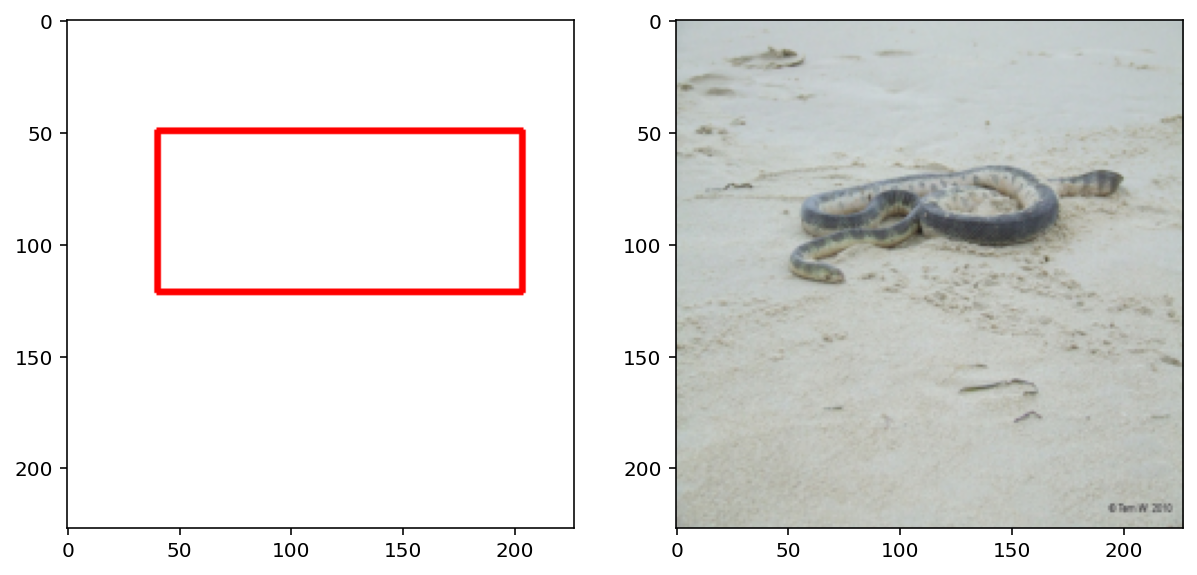

In [ ]:
nimg = format_for_plotting(img[0])
rimg = np.ones(nimg.shape)
fig , (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))

cv.rectangle(rimg,pred_bb[0],pred_bb[1],(255,0,0),2)

ax1.imshow(rimg)
ax2.imshow(nimg)

In [ ]:
img[0].shape

torch.Size([1, 3, 224, 224])